### Compatibilidad

In [1]:
import torch, transformers, datasets, peft, accelerate, bitsandbytes as bnb
import diffusers, PIL
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
print("transformers:", transformers.__version__)
print("datasets:", datasets.__version__)
print("peft:", peft.__version__)
print("accelerate:", accelerate.__version__)
print("bnb:", bnb.__version__)
print("diffusers:", diffusers.__version__)

torch: 2.6.0+cu124
cuda available: True
transformers: 4.56.2
datasets: 4.1.1
peft: 0.17.1
accelerate: 1.10.1
bnb: 0.47.0
diffusers: 0.35.1


# Fase A: Preprocesamiento del dataset

### A0) Preparación y utilidades

In [2]:
# === A0. IMPORTS, RUTAS, DISPOSITIVO, UTILS ===
from pathlib import Path
import os, json, math, gc
import pandas as pd
import numpy as np
from typing import List, Dict, Any

# tqdm opcional
try:
    from tqdm.auto import tqdm
except Exception:
    def tqdm(x, **k): 
        return x

# Torch / HF
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Rutas
BASE = Path("data")
IMG_DIR = BASE / "img"
TRAIN_JSONL = BASE / "train.jsonl"
DEV_JSONL   = BASE / "dev.jsonl"
TEST_JSONL  = BASE / "test.jsonl"
OUT_DIR = BASE / "processed"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Helper para leer .jsonl en DataFrame
def read_jsonl(path: Path, split_name: str) -> pd.DataFrame:
    assert path.exists(), f"No existe: {path}"
    rows = []
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            if line.strip():
                rows.append(json.loads(line))
    df = pd.DataFrame(rows)
    df["split"] = split_name
    # normaliza nombres de columnas esperadas
    # dataset trae 'text', 'img', y 'label' (label no está en test)
    if "label" not in df.columns:
        df["label"] = np.nan
    return df[["text", "img", "label", "split"]]

print("Estructura OK.")

Device: cuda
Estructura OK.


### A1) Carga de splits + validación de imágenes

In [3]:
# === A1. CARGA DE TRAIN/DEV/TEST Y LIMPIEZA BÁSICA ===
df_train = read_jsonl(TRAIN_JSONL, "train")
df_dev   = read_jsonl(DEV_JSONL,   "dev")
df_test  = read_jsonl(TEST_JSONL,  "test")

df = pd.concat([df_train, df_dev, df_test], ignore_index=True)

# Limpieza mínima del texto
def clean_text(s):
    if not isinstance(s, str): 
        return ""
    s = s.replace("\n", " ").strip()
    s = " ".join(s.split())
    return s

df["text"] = df["text"].apply(clean_text)

# Resuelve ruta absoluta de imagen
df["img_path"] = df["img"].apply(lambda p: str((IMG_DIR / Path(p).name).resolve()))

# Validación de existencia de imagen
df["img_exists"] = df["img_path"].apply(lambda p: Path(p).exists())
missing = (~df["img_exists"]).sum()
print(f"Total filas: {len(df)} | Imágenes faltantes: {missing}")

# Filtramos si quieres (opcional): dejar solo filas con imagen existente
df_ok = df[df["img_exists"]].copy().reset_index(drop=True)

# Resumen por split
print(df_ok.groupby("split")["label"].agg(["count", "nunique"]).rename(columns={"count":"filas","nunique":"clases_en_label"}))
df_ok.head(3)

Total filas: 10000 | Imágenes faltantes: 0
       filas  clases_en_label
split                        
dev      500                2
test       0                0
train   8500                2


,text,img,label,split,img_path,img_exists
0,its their character not their color that matters,img/42953.png,0.0,train,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,True
1,don't be afraid to love again everyone is not ...,img/23058.png,0.0,train,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,True
2,putting bows on your pet,img/13894.png,0.0,train,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,True


### A3) Inferencia de emociones (GoEmotions) por lote

In [4]:
# === A3. EMOCIONES (GoEmotions-like) ===
EMO_MODEL = "joeddav/distilbert-base-uncased-go-emotions-student"  # liviano y muy usado
emo_tok = AutoTokenizer.from_pretrained(EMO_MODEL, use_fast=True)
emo_mdl = AutoModelForSequenceClassification.from_pretrained(EMO_MODEL)
emo_mdl.to(device).eval()

id2label_emo = emo_mdl.config.id2label
num_labels_emo = emo_mdl.config.num_labels
print("Emo labels:", id2label_emo)

def batched(iterable, n=32):
    for i in range(0, len(iterable), n):
        yield iterable[i:i+n]

all_texts = df_ok["text"].tolist()
emo_top = []
emo_score = []

with torch.no_grad():
    for chunk in tqdm(list(batched(all_texts, 64)), total=math.ceil(len(all_texts)/64)):
        enc = emo_tok(chunk, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        logits = emo_mdl(**enc).logits
        probs = torch.softmax(logits, dim=-1)
        smax, idx = probs.max(dim=-1)
        emo_top.extend([id2label_emo[int(i)] for i in idx.cpu()])
        emo_score.extend([float(s) for s in smax.cpu()])

df_ok["emotion"] = emo_top
df_ok["emotion_score"] = emo_score

df_ok[["split","text","emotion","emotion_score"]].head(5)

Emo labels: {0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


  0%|          | 0/157 [00:00<?, ?it/s]

,split,text,emotion,emotion_score
0,train,its their character not their color that matters,confusion,0.141711
1,train,don't be afraid to love again everyone is not ...,love,0.141409
2,train,putting bows on your pet,caring,0.123281
3,train,i love everything and everybody! except for sq...,realization,0.116181
4,train,"everybody loves chocolate chip cookies, even h...",excitement,0.119929


### A4) Inferencia de ironía/sarcasmo (modelo binario)

In [5]:
# === A4. IRONÍA / SARCASMO ===
IRONY_MODEL = "cardiffnlp/twitter-roberta-base-irony"
ir_tok = AutoTokenizer.from_pretrained(IRONY_MODEL, use_fast=True)
ir_mdl = AutoModelForSequenceClassification.from_pretrained(IRONY_MODEL)
ir_mdl.to(device).eval()

id2label_ir = ir_mdl.config.id2label
print("Irony labels:", id2label_ir)  # p.ej. {0:'non_irony', 1:'irony'}

ir_score = []
ir_label = []

with torch.no_grad():
    for chunk in tqdm(list(batched(all_texts, 64)), total=math.ceil(len(all_texts)/64)):
        enc = ir_tok(chunk, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        logits = ir_mdl(**enc).logits
        probs = torch.softmax(logits, dim=-1)
        irony_p = probs[:, 1]  # prob de clase "irony"
        pred = (irony_p >= 0.5).long()
        ir_score.extend([float(p) for p in irony_p.detach().cpu()])
        ir_label.extend([id2label_ir[int(i)] for i in pred.detach().cpu()])

df_ok["irony_score"] = ir_score
df_ok["irony_label"] = ir_label

df_ok[["split","text","irony_label","irony_score"]].head(5)

Irony labels: {0: 'non_irony', 1: 'irony'}


  0%|          | 0/157 [00:00<?, ?it/s]

,split,text,irony_label,irony_score
0,train,its their character not their color that matters,non_irony,0.133972
1,train,don't be afraid to love again everyone is not ...,non_irony,0.078102
2,train,putting bows on your pet,irony,0.782739
3,train,i love everything and everybody! except for sq...,non_irony,0.459435
4,train,"everybody loves chocolate chip cookies, even h...",irony,0.835836


### A5) Síntesis de tono (heurística simple)

Derivamos un tono combinando emoción e ironía:

Si irony_score ≥ 0.5 → tone = "irony".

Si emoción en {amusement, joy} y score alto → tone = "humor".

Si no, tone = "neutral" (o la emoción top, si prefieres).

In [6]:
# === A5b. REDEFINIR TONE -> tone_v2 con mezcla de señales ===
import re
import numpy as np

# 1) Conjunto de emociones que suelen correlacionar con humor
HUMOR_EMOS = {
    "amusement","joy","excitement","surprise","pride","love",
    "optimism","approval","gratitude","relief"
}

# 2) Señales léxicas simples en texto de memes (puedes ampliar)
LEX_HUMOR_PAT = re.compile(
    r"(ha(ha)+|he(he)+|lol|lmao|rofl|xd|xD|:D|;-\)|;\)|🙂|😅|😂|🤣)",
    flags=re.IGNORECASE
)

def lex_humor_score(text: str) -> float:
    if not isinstance(text, str) or not text:
        return 0.0
    m = LEX_HUMOR_PAT.findall(text)
    # 0.0 (nada)  ~  0.2 (varias señales)
    return min(0.2, 0.05 * len(m))  # 0.05 por match, cap en 0.2

def humor_score_row(emotion: str, emo_s: float, irony_s: float, text: str) -> float:
    # ponderaciones: emoción (0.6), ironía (0.3), léxico (0.1)
    w_emo, w_ir, w_lex = 0.6, 0.3, 0.1
    emo_term = emo_s if (emotion or "").lower() in HUMOR_EMOS else 0.0
    ir_term  = irony_s * 0.6  # suavizamos ironía al 60% dentro del 0.3
    lex_term = lex_humor_score(text)
    return (w_emo * emo_term) + (w_ir * ir_term) + (w_lex * lex_term)

# Calcula humor_score
df_ok["humor_score"] = [
    humor_score_row(e, es, is_, t)
    for e, es, is_, t in zip(df_ok["emotion"], df_ok["emotion_score"], df_ok["irony_score"], df_ok["text"])
]

# 3 variantes de decisión
def decide_tone_variant(irony_s, humor_s, variant="balanced"):
    # Regla común: ironía alta gana a humor
    if irony_s >= 0.60:
        return "irony"

    if variant == "conservative":
        thr = 0.40  # pide humor_score alto
    elif variant == "generous":
        thr = 0.28  # etiqueta más casos como humor
    else:  # balanced
        # Umbral adaptativo: max(0.32, p70 de humor_score en TRAIN)
        train_scores = df_ok.loc[df_ok["split"]=="train", "humor_score"]
        q70 = float(train_scores.quantile(0.70)) if len(train_scores) else 0.35
        thr = max(0.32, q70)

    if humor_s >= thr:
        return "humor"
    return "neutral"

for v in ["conservative", "balanced", "generous"]:
    col = f"tone_{v}"
    df_ok[col] = [
        decide_tone_variant(ir, hu, v)
        for ir, hu in zip(df_ok["irony_score"], df_ok["humor_score"])
    ]
    print(f"\n>>> Variante: {v}")
    print(df_ok.groupby(["split", col]).size().unstack(fill_value=0))

# Elegimos 'balanced' como predeterminado
df_ok["tone_v2"] = df_ok["tone_balanced"]

# Guardamos un CSV nuevo
meta_v2 = OUT_DIR / "metadata_v2.csv"
cols = ["split","img_path","img","text","label",
        "emotion","emotion_score","irony_score","humor_score","tone_v2"]
df_ok[cols].to_csv(meta_v2, index=False, encoding="utf-8")
print(f"\nGuardado: {meta_v2.resolve()} | Filas: {len(df_ok)}")


>>> Variante: conservative
tone_conservative  humor  irony  neutral
split                                   
dev                    0    212      288
test                   1    451      548
train                  2   3588     4910

>>> Variante: balanced
tone_balanced  humor  irony  neutral
split                               
dev                0    212      288
test               7    451      542
train             12   3588     4900

>>> Variante: generous
tone_generous  humor  irony  neutral
split                               
dev                2    212      286
test               9    451      540
train             32   3588     4880

Guardado: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\data\processed\metadata_v2.csv | Filas: 10000


In [7]:
# === A5c. TONE_v3 con objetivo de % humor por split (percentil) ===
from pathlib import Path
import pandas as pd, numpy as np, re, math

BASE = Path("data")
OUT_DIR = BASE / "processed"
meta_v2 = OUT_DIR / "metadata_v2.csv"
meta_v1 = OUT_DIR / "metadata.csv"
assert meta_v2.exists() or meta_v1.exists(), "No encuentro metadata_v2.csv ni metadata.csv"

df = pd.read_csv(meta_v2 if meta_v2.exists() else meta_v1)

# --- Parámetros ajustables ---
I_HIGH = 0.75             # umbral "irony alta" -> clase 'irony'
HUMOR_TARGET_PCT = 0.20   # proporción objetivo de humor por split (20%)
MIN_HUMOR_PER_SPLIT = 10  # al menos N ejemplos humor por split (si hay suficientes candidatos)

# --- Señales léxicas para humor (más peso que antes) ---
LEX_HUMOR_PAT = re.compile(
    r"(ha(ha)+|he(he)+|ja(ja)+|lol|lmao|rofl|xd|xD|:D|;-\)|;\)|🙂|😅|😂|🤣)",
    flags=re.IGNORECASE
)
def lex_humor_score(text: str) -> float:
    if not isinstance(text, str) or not text:
        return 0.0
    m = LEX_HUMOR_PAT.findall(text)
    # Subimos el peso léxico: hasta 0.35 máx.
    return min(0.35, 0.07 * len(m))  # 0.07 por match

# --- Recalcular humor_score_v2 (más permisivo) ---
# Si existen columnas, úsalas; si no, asigna neutros razonables.
df["emotion"] = df.get("emotion", "").fillna("")
df["emotion_score"] = df.get("emotion_score", 0.0).fillna(0.0)
df["irony_score"] = df.get("irony_score", 0.0).fillna(0.0)
df["text"] = df.get("text", "").fillna("")

HUMOR_EMOS = {
    # ampliamos conjunto "pro-humor"
    "amusement","joy","excitement","surprise","pride","love",
    "optimism","approval","gratitude","relief","desire","caring"
}

def humor_score_v2_row(emotion, emo_s, irony_s, text):
    # Ponderaciones más permisivas: bajamos emoción, subimos léxico
    w_emo, w_ir, w_lex = 0.45, 0.35, 0.20
    emo_term = emo_s if str(emotion).lower() in HUMOR_EMOS else 0.0
    ir_term  = irony_s * 0.5     # ironía contribuye pero menos que antes
    lex_term = lex_humor_score(text)
    score = (w_emo * emo_term) + (w_ir * ir_term) + (w_lex * lex_term)
    return float(min(1.0, score))

df["humor_score_v2"] = [
    humor_score_v2_row(e, es, ir, t)
    for e, es, ir, t in zip(df["emotion"], df["emotion_score"], df["irony_score"], df["text"])
]

# --- Asignación 'irony' por umbral alto ---
df["tone_v3"] = np.where(df["irony_score"] >= I_HIGH, "irony", None)

# --- Selección de candidatos a 'humor' por split ---
def assign_humor_by_percentile(group: pd.DataFrame) -> pd.Series:
    g = group.copy()

    # candidatos: (no irónicos altos) y (no-hateful cuando label exista)
    cond_ir = g["irony_score"] < I_HIGH
    cond_lbl = (~g["label"].isna() & (g["label"] == 0)) | (g["label"].isna())
    cand = g[cond_ir & cond_lbl]

    if len(cand) == 0:
        # nada que etiquetar como humor
        return g["tone_v3"].fillna("neutral")

    # cuántos queremos marcar como humor
    k = max(MIN_HUMOR_PER_SPLIT, int(round(HUMOR_TARGET_PCT * len(g))))
    k = min(k, len(cand))  # no exceder candidatos

    # si k==0 pero hay candidatos, fuerza al menos 1 (si quieres)
    if k == 0 and len(cand) > 0:
        k = 1

    # Umbral por percentil: escogemos top-k de humor_score_v2 entre candidatos
    cand_sorted = cand.sort_values("humor_score_v2", ascending=False)
    humor_idx = set(cand_sorted.index[:k])

    # Inicial: neutral donde no hay tono asignado
    tone = g["tone_v3"].copy()
    tone = tone.fillna("neutral")

    # Asignar humor para top-k candidatos (no pisa 'irony')
    mask_assign = g.index.isin(humor_idx) & (tone != "irony")
    tone.loc[mask_assign] = "humor"
    return tone

df["tone_v3"] = df.groupby("split", group_keys=False).apply(assign_humor_by_percentile)

# --- Resumen y guardado ---
print("Distribución por split (tone_v3):")
print(df.groupby(["split","tone_v3"]).size().unstack(fill_value=0))

out_path = OUT_DIR / "metadata_v3.csv"
cols = ["split","img_path","img","text","label",
        "emotion","emotion_score","irony_score","humor_score_v2","tone_v3"]
# mantener columnas que existan
cols = [c for c in cols if c in df.columns]
df[cols].to_csv(out_path, index=False, encoding="utf-8")
print(f"\nGuardado: {out_path.resolve()} | Filas: {len(df)}")

Distribución por split (tone_v3):
tone_v3  humor  irony  neutral
split                         
dev        100    153      247
test       200    315      485
train     1700   2439     4361

Guardado: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\data\processed\metadata_v3.csv | Filas: 10000


C:\Users\fabri\AppData\Local\Temp\ipykernel_27748\1467571867.py:94: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df["tone_v3"] = df.groupby("split", group_keys=False).apply(assign_humor_by_percentile)


### A7) Vista rápida de ejemplos

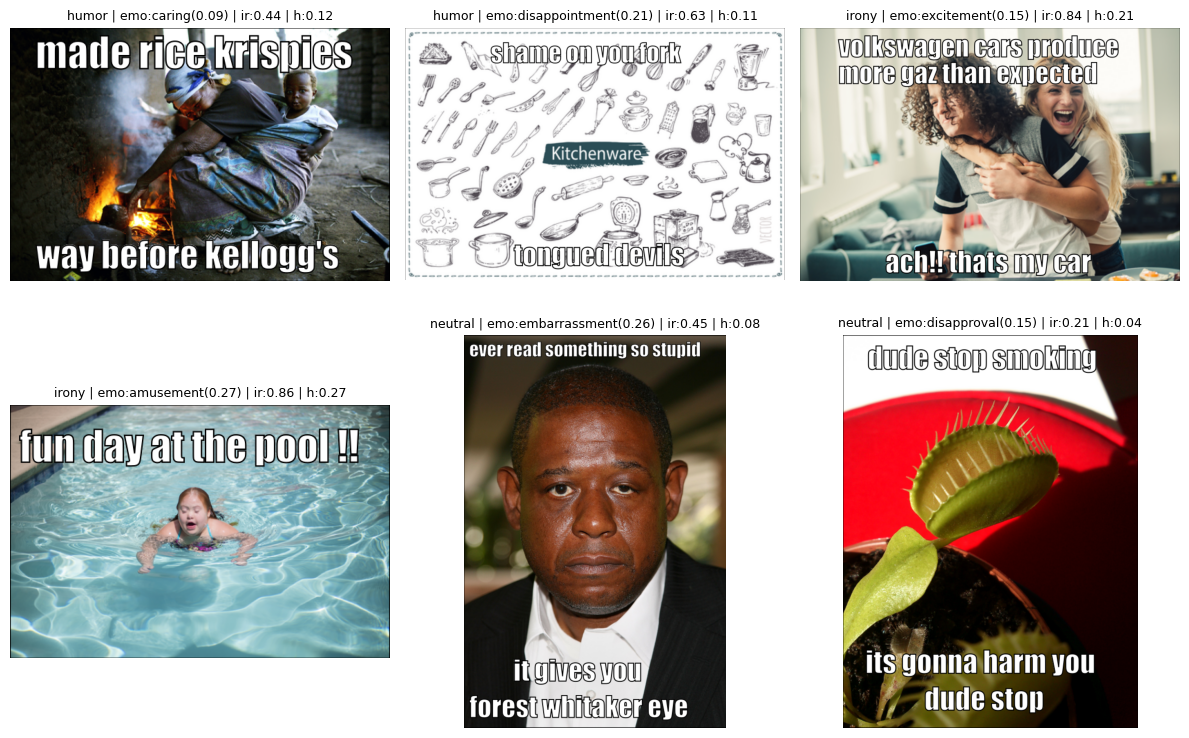

In [8]:
# === A7 (v2). PREVISUALIZACIÓN RÁPIDA CON tone_v3 ===
from pathlib import Path
import pandas as pd, math
from PIL import Image
import matplotlib.pyplot as plt

META = Path("data/processed/metadata_v3.csv")
assert META.exists(), f"No encuentro {META}"

df_vis = pd.read_csv(META)

# Aseguramos columnas y filtramos imágenes existentes
for col in ["emotion_score","irony_score","humor_score_v2"]:
    if col not in df_vis.columns:
        df_vis[col] = 0.0
if "tone_v3" not in df_vis.columns:
    # fallback por si alguien carga metadata vieja
    df_vis["tone_v3"] = df_vis.get("tone", "neutral")

df_vis = df_vis[df_vis["img_path"].apply(lambda p: Path(p).exists())].reset_index(drop=True)

# Muestreo estratificado: hasta 2 por clase (humor/irony/neutral)
samples = []
for cls in ["humor", "irony", "neutral"]:
    sub = df_vis[df_vis["tone_v3"] == cls]
    if len(sub) > 0:
        samples.append(sub.sample(n=min(2, len(sub)), random_state=42))

if samples:
    sample = pd.concat(samples, ignore_index=True)
else:
    sample = df_vis.sample(n=min(6, len(df_vis)), random_state=42)

n = len(sample)
plt.figure(figsize=(12, 8))
for i, (_, row) in enumerate(sample.iterrows(), 1):
    try:
        img = Image.open(row["img_path"]).convert("RGB")
        plt.subplot(math.ceil(n/3), 3, i)
        plt.imshow(img); plt.axis("off")
        ttl = (
            f"{row['tone_v3']} | "
            f"emo:{row.get('emotion','?')}({row.get('emotion_score',0):.2f}) | "
            f"ir:{row.get('irony_score',0):.2f} | "
            f"h:{row.get('humor_score_v2',0):.2f}"
        )
        plt.title(ttl, fontsize=9)
    except Exception:
        pass
plt.tight_layout(); plt.show()

# Fase B — Crear caption templates (prompts) y un CSV de entrenamiento

### B0) Cargar metadata y filtrar ejemplos de entrenamiento

Usamos solo split=train.

Excluimos label==1 (hateful) para no inducir ese contenido.

Aceptamos tone_v3 ∈ {humor, irony, neutral} (puedes ajustar).

In [9]:
# === B0. CARGA Y FILTRO DE ENTRENAMIENTO ===
from pathlib import Path
import pandas as pd

BASE = Path("data")
META = BASE / "processed" / "metadata_v3.csv"
assert META.exists(), f"No encuentro {META}"

df = pd.read_csv(META)

# Filtrado base: train, imagen existente, no-hateful (o sin label)
from pathlib import Path
df = df[(df["split"]=="train") & (df["img_path"].apply(lambda p: Path(p).exists()))].copy()

if "label" in df.columns:
    df = df[(df["label"].isna()) | (df["label"]==0)].copy()  # solo no-hateful

# Mantén estas clases (puedes quitar 'irony' si prefieres)
ALLOWED_TONES = {"humor","neutral","irony"}
df = df[df["tone_v3"].isin(ALLOWED_TONES)].copy().reset_index(drop=True)

print("Post-filtro:")
print(df["tone_v3"].value_counts())
print("Filas:", len(df))
df.head(3)

Post-filtro:
tone_v3
neutral    2201
humor      1700
irony      1549
Name: count, dtype: int64
Filas: 5450


,split,img_path,img,text,label,emotion,emotion_score,irony_score,humor_score_v2,tone_v3
0,train,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,img/42953.png,its their character not their color that matters,0.0,confusion,0.141711,0.133972,0.023445,neutral
1,train,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,img/23058.png,don't be afraid to love again everyone is not ...,0.0,love,0.141409,0.078102,0.077302,neutral
2,train,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,img/13894.png,putting bows on your pet,0.0,caring,0.123281,0.782739,0.192456,irony


### B1) Generador de prompts (templates)

Idea: inducir estilo “meme” + tono + topic del texto original (cuidando seguridad).

Añadimos modificadores visuales útiles (reaction shot, high-contrast, cinematic lighting, etc.).

Guardamos también un negative_prompt (para la inferencia posterior).

In [10]:
# === B1. CAPTION TEMPLATES / PROMPT BUILDER ===
import re, random

# Stopwords mini (en inglés, por si quieres limpiar topic; opcional)
STOP = set("""
a an and the of to in on for with at by from as is are was were be been being you your
i me my we us our they them their he she it its that this these those when while just
""".split())

VISUAL_TAGS = [
    "high-contrast photo",
    "reaction shot",
    "dramatic scene",
    "cinematic lighting",
    "vivid details",
    "natural skin tones",
    "photorealistic",
    "shallow depth of field",
    "stock photo style",
    "vintage look"
]

BASE_TONE = {
    "humor":  "sarcastic meme",
    "irony":  "ironic meme",
    "neutral":"meme"
}

def sanitize_topic(text: str, max_len: int = 140) -> str:
    if not isinstance(text, str) or not text.strip():
        return "an everyday awkward situation"
    t = text.strip()
    # quita comillas dobles, saltos
    t = t.replace("\n"," ").replace("\r"," ").replace('"',"'")
    # colapsa espacios
    t = " ".join(t.split())
    # recorta suave
    if len(t) > max_len:
        t = t[:max_len-3].rstrip()+"..."
    return t

def make_prompt(row) -> str:
    tone = row.get("tone_v3","neutral")
    base = BASE_TONE.get(tone, "meme")
    topic = sanitize_topic(row.get("text",""))
    vis = ", ".join(random.sample(VISUAL_TAGS, k=3))
    # Plantilla principal
    prompt = f"{base} about {topic}, {vis}"
    return prompt

NEGATIVE_PROMPT = (
    "nsfw, hate speech, slur, offensive text, watermark, logo, low quality, blurry, "
    "jpeg artifacts, extra fingers, deformed, text overlay, caption text"
)

# Prueba sobre 5 filas aleatorias
sample_prompts = [make_prompt(r) for _, r in df.sample(n=min(5,len(df)), random_state=42).iterrows()]
for i, p in enumerate(sample_prompts, 1):
    print(f"[{i}] {p}")
print("\nnegative_prompt:", NEGATIVE_PROMPT)

[1] sarcastic meme about if a man wants you, he will come and get you, photorealistic, high-contrast photo, cinematic lighting
[2] ironic meme about everyone knows hitting appliances that stop working, sometimes fixes the problem, vivid details, high-contrast photo, photorealistic
[3] sarcastic meme about people will do shit like this but lock their door when someone sketchy walk by, shallow depth of field, high-contrast photo, dramatic scene
[4] meme about thats a little savage, reaction shot, high-contrast photo, vivid details
[5] ironic meme about holocaust makes me sad!, natural skin tones, vivid details, high-contrast photo

negative_prompt: nsfw, hate speech, slur, offensive text, watermark, logo, low quality, blurry, jpeg artifacts, extra fingers, deformed, text overlay, caption text


### B2) Balanceo por clase 

Queremos reforzar el estilo humor/irony frente a neutral para el LoRA de estilo.

Define la proporción objetivo y hacemos oversampling con reemplazo donde haga falta.

In [11]:
# === B2. BALANCEO DE TONOS (OVERSAMPLING) ===
import math

# Objetivo (ajusta a gusto)
TARGET_RATIOS = {
    "humor": 0.50,   # 50%
    "irony": 0.20,   # 20%
    "neutral": 0.30  # 30%
}
assert abs(sum(TARGET_RATIOS.values()) - 1.0) < 1e-6

N_TOTAL = len(df)  # puedes fijar un total objetivo si deseas (e.g., 6000)
weights = {}
frames = []

for tone, ratio in TARGET_RATIOS.items():
    sub = df[df["tone_v3"]==tone]
    k = int(round(ratio * N_TOTAL))
    if len(sub) == 0:
        continue
    # muestreo con reemplazo si hace falta
    take = sub.sample(
        n=min(k, len(sub)),
        random_state=123,
        replace=False
    )
    if k > len(sub):
        extra = sub.sample(n=(k - len(sub)), random_state=456, replace=True)
        take = pd.concat([take, extra], ignore_index=True)
    frames.append(take)

df_bal = pd.concat(frames, ignore_index=True)
df_bal = df_bal.sample(frac=1.0, random_state=999).reset_index(drop=True)

print("Distribución objetivo vs obtenida:")
print("Objetivo:", TARGET_RATIOS)
print(df_bal["tone_v3"].value_counts(normalize=True).round(3))
print("Filas balanceadas:", len(df_bal))

Distribución objetivo vs obtenida:
Objetivo: {'humor': 0.5, 'irony': 0.2, 'neutral': 0.3}
tone_v3
humor      0.5
neutral    0.3
irony      0.2
Name: proportion, dtype: float64
Filas balanceadas: 5450


### B3) Construcción del CSV de entrenamiento (imagen ↔ prompt)

Creamos train_lora_prompts.csv con image_path, prompt, negative_prompt, tone.

In [12]:
# === B3. CONSTRUIR CSV ENTRENAMIENTO (imagen ↔ prompt) ===
OUT = BASE / "processed" / "train_lora_prompts.csv"

rows = []
for _, row in df_bal.iterrows():
    rows.append({
        "image_path": row["img_path"],
        "prompt":     make_prompt(row),
        "negative_prompt": NEGATIVE_PROMPT,
        "tone":       row["tone_v3"]
    })

df_prompts = pd.DataFrame(rows)
df_prompts.to_csv(OUT, index=False, encoding="utf-8")
print(f"Guardado: {OUT.resolve()} | Filas: {len(df_prompts)}")
df_prompts.head(5)

Guardado: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\data\processed\train_lora_prompts.csv | Filas: 5450


,image_path,prompt,negative_prompt,tone
0,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,sarcastic meme about let me make this clear: i...,"nsfw, hate speech, slur, offensive text, water...",humor
1,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,meme about im mixed with what? gorilla and rhi...,"nsfw, hate speech, slur, offensive text, water...",neutral
2,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,ironic meme about when white folks announce th...,"nsfw, hate speech, slur, offensive text, water...",irony
3,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,ironic meme about pot holes what a great way t...,"nsfw, hate speech, slur, offensive text, water...",irony
4,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,meme about nice watch must have cost an arm an...,"nsfw, hate speech, slur, offensive text, water...",neutral


### B4) Chequeo rápido de calidad de prompts

Longitud media / percentiles.

Ejemplos por clase.

Duplicados de imagen o prompt (para evitar overfitting por repetición exacta).

In [13]:
# === B4. QA RÁPIDO DE PROMPTS ===
import numpy as np

df_prompts["len_prompt"] = df_prompts["prompt"].str.len()
print("Len(prompt): mean", df_prompts["len_prompt"].mean().round(1),
      "| p50", np.percentile(df_prompts["len_prompt"],50).round(1),
      "| p90", np.percentile(df_prompts["len_prompt"],90).round(1))

print("\nPor tono:")
print(df_prompts["tone"].value_counts())

# Duplicados
dup_img = df_prompts["image_path"].duplicated().sum()
dup_prm = df_prompts["prompt"].duplicated().sum()
print(f"\nDuplicados -> image_path: {dup_img} | prompt: {dup_prm}")

# Muestra 2 ejemplos por tono
ex = []
for t in ["humor","irony","neutral"]:
    sub = df_prompts[df_prompts["tone"]==t]
    if len(sub)>0:
        ex.append(sub.sample(n=min(2,len(sub)), random_state=7))
if ex:
    display(pd.concat(ex))

Len(prompt): mean 127.8 | p50 121.0 | p90 173.0

Por tono:
tone
humor      2725
neutral    1635
irony      1090
Name: count, dtype: int64

Duplicados -> image_path: 1025 | prompt: 4


,image_path,prompt,negative_prompt,tone,len_prompt
2016,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,sarcastic meme about hey kids for a good time ...,"nsfw, hate speech, slur, offensive text, water...",humor,120
2425,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,sarcastic meme about and just like that.. i'm ...,"nsfw, hate speech, slur, offensive text, water...",humor,112
3604,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,ironic meme about how a black woman can fight ...,"nsfw, hate speech, slur, offensive text, water...",irony,115
4859,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,ironic meme about here's to the mothers who ra...,"nsfw, hate speech, slur, offensive text, water...",irony,165
1208,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,meme about it was on that day tom had enough o...,"nsfw, hate speech, slur, offensive text, water...",neutral,111
4803,C:\Users\fabri\Desktop\Portfolio\SarcasmDiffus...,meme about my sandwich-maker is very slow toda...,"nsfw, hate speech, slur, offensive text, water...",neutral,106


### B5) Test del pipeline de generación

In [14]:
# === B5. SMOKE TEST DE GENERACIÓN BASE (opcional, 10-15s) ===
import torch
from diffusers import AutoPipelineForText2Image
from PIL import Image

test_row = df_prompts.sample(1, random_state=123).iloc[0]
prompt = test_row["prompt"]
neg = test_row["negative_prompt"]
print("Prompt test:\n", prompt)

model_id = "stabilityai/stable-diffusion-2-1"  # puedes usar SDXL en la fase de entrenamiento real
pipe = AutoPipelineForText2Image.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    variant="fp16",
).to("cuda")

image = pipe(prompt, negative_prompt=neg, num_inference_steps=12, guidance_scale=7.0).images[0]
out_img = BASE / "processed" / "smoke_test_sd21.png"
image.save(out_img)
print("Imagen generada:", out_img.resolve())

Prompt test:
 sarcastic meme about i got a flat on my way to the store, dramatic scene, cinematic lighting, stock photo style


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/12 [00:00<?, ?it/s]

Imagen generada: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\data\processed\smoke_test_sd21.png


# Fase C: Entrenamiento LoRA sobre SDXL

In [15]:
# === C0. CONFIG ===
from pathlib import Path

# Rutas
BASE = Path("data")
CSV  = BASE / "processed" / "train_lora_prompts.csv"   # creado en Fase B
OUT  = Path("models") / "lora_sdxl_meme"               # carpeta de salida
OUT.mkdir(parents=True, exist_ok=True)

# Entrenamiento
SEED          = 42
RESOLUTION    = 1024          # 1024 recomendado para SDXL (si falta VRAM usa 896 o 768)
BATCH_SIZE    = 1             # sube a 2 si tu VRAM alcanza
GRAD_ACCUM    = 4             # acumulación para simular batch mayor
MAX_STEPS     = 9000          
LEARNING_RATE = 1e-4
LORA_R        = 8
LORA_ALPHA    = 16
LORA_DROPOUT  = 0.05

print("CSV:", CSV.resolve())
print("OUT:", OUT.resolve())

CSV: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\data\processed\train_lora_prompts.csv
OUT: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\lora_sdxl_meme


### C1) Dataset y transforms

In [16]:
# === C1. DATASET ===
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import random

g_cpu = torch.Generator().manual_seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

dfp = pd.read_csv(CSV)
assert len(dfp) > 0, "train_lora_prompts.csv vacío"
print("Filas:", len(dfp))
dfp.head(2)

class MemeDataset(Dataset):
    def __init__(self, df, size=1024):
        self.df = df.reset_index(drop=True)
        self.size = size

    def __len__(self):
        return len(self.df)

    def _load_image(self, path):
        img = Image.open(path).convert("RGB")
        # resize + center crop cuadrado
        short = min(img.size)
        left = (img.width - short)//2
        top  = (img.height - short)//2
        img  = img.crop((left, top, left+short, top+short))
        img  = img.resize((self.size, self.size), Image.BICUBIC)
        arr  = np.array(img).astype(np.float32) / 255.0
        # normalizar a [-1, 1] que es lo que espera el VAE
        arr  = (arr * 2.0) - 1.0
        # HWC->CHW
        arr  = np.transpose(arr, (2,0,1))
        return torch.from_numpy(arr)

    def __getitem__(self, idx):
        r = self.df.iloc[idx]
        image = self._load_image(r["image_path"])
        prompt = str(r["prompt"])
        return {
            "pixel_values": image,
            "prompt": prompt
        }

# === C1. DATASET + DATALOADER (Windows/Notebook safe) ===
train_ds = MemeDataset(dfp, size=RESOLUTION)
train_dl = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,            # <- clave en Windows/Notebook
    pin_memory=False,         # opcional evitar overhead
    persistent_workers=False  # por si lo cambias a >0 en scripts
)
print("Batches/epoch:", len(train_dl))

Filas: 5450
Batches/epoch: 5450


### C2) Cargar SDXL + inyectar LoRA en UNet

In [17]:
# === C2. SDXL + LoRA (UNet) — FIX ===
import torch
from diffusers import DiffusionPipeline, DDPMScheduler
from accelerate import Accelerator
from peft import LoraConfig  # <- viene de peft, no de diffusers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
acc = Accelerator(mixed_precision="fp16", gradient_accumulation_steps=GRAD_ACCUM)

pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
pipe.to(device)

# Congelar todo menos LoRA en UNet
pipe.unet.requires_grad_(False)
pipe.vae.requires_grad_(False)
pipe.text_encoder.requires_grad_(False)
pipe.text_encoder_2.requires_grad_(False)

# Ahorro de VRAM
pipe.unet.enable_gradient_checkpointing()
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass

# Inyectar LoRA en UNet (API nueva con peft.LoraConfig)
lora_cfg = LoraConfig(
    r=LORA_R,
    lora_alpha=LORA_ALPHA,
    lora_dropout=LORA_DROPOUT,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],  # capas de atención
)

# diffusers>=0.30 expone add_adapter en los módulos
assert hasattr(pipe.unet, "add_adapter"), "Tu versión de diffusers no expone unet.add_adapter"
pipe.unet.add_adapter(lora_cfg, adapter_name="sarcasm")  # crea adapter 'sarcasm'
pipe.unet.set_adapters(["sarcasm"])                      # lo activamos
pipe.unet.train()

# Parámetros entrenables = sólo LoRA del UNet
trainable_params = [p for n,p in pipe.unet.named_parameters() if p.requires_grad]
print("Parámetros LoRA (UNet) entrenables:",
      round(sum(p.numel() for p in trainable_params)/1e6, 3), "M")

# === cast LoRA params to FP32 ===
for n, p in pipe.unet.named_parameters():
    if p.requires_grad:           # <- solo LoRA
        p.data = p.data.to(torch.float32)

# recrea la lista tras el cast
trainable_params = [p for n,p in pipe.unet.named_parameters() if p.requires_grad]
print("Dtype trainable unique:", {p.dtype for p in trainable_params})  # debería ser {torch.float32}

# Optimizador (después del cast)
optimizer = torch.optim.AdamW(trainable_params, lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.0)

# Re-prepare con accelerate por seguridad
pipe.unet, optimizer, train_dl = acc.prepare(pipe.unet, optimizer, train_dl)

# Optimizador
optimizer = torch.optim.AdamW(trainable_params, lr=LEARNING_RATE, betas=(0.9, 0.999), weight_decay=0.0)

# Preparar con accelerate
pipe.unet, optimizer, train_dl = acc.prepare(pipe.unet, optimizer, train_dl)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Parámetros LoRA (UNet) entrenables: 11.612 M
Dtype trainable unique: {torch.float32}


### C3) Loop de entrenamiento (MSE sobre ruido)

Para SDXL necesitamos prompt embeds, pooled embeds y time ids. Usamos utilidades del propio pipeline para codificar prompts.

In [18]:
# === C3 LOOP DE ENTRENAMIENTO SDXL+LoRA ===
import torch
import torch.nn.functional as F
from tqdm.auto import tqdm
import math, os

global_step = 0

# Atajos a módulos
vae = pipe.vae
unet = pipe.unet
tokenizer_1 = pipe.tokenizer
tokenizer_2 = pipe.tokenizer_2
text_encoder_1 = pipe.text_encoder
text_encoder_2 = pipe.text_encoder_2
noise_scheduler = pipe.scheduler

# Congelados en eval; UNet en train
vae.eval(); text_encoder_1.eval(); text_encoder_2.eval()
unet.train()  # <- el que sí se entrena (LoRA)

# SDXL: time ids -> (orig_h, orig_w, crop_y, crop_x, target_h, target_w)
def build_time_ids(bsz, h, w, device):
    return torch.tensor([h, w, 0, 0, h, w], device=device).repeat(bsz, 1)

acc.print(f"Entrenando por {MAX_STEPS} steps (≈ {math.ceil(MAX_STEPS/len(train_dl))} epochs)")
progress = tqdm(total=MAX_STEPS, disable=not acc.is_local_main_process)
optimizer.zero_grad(set_to_none=True)

while global_step < MAX_STEPS:
    for batch in train_dl:
        with acc.accumulate(unet):
            # 1) imagen -> latentes
            pixel_values = batch["pixel_values"].to(acc.device, dtype=torch.float16)
            latents = vae.encode(pixel_values).latent_dist.sample()
            latents = latents * vae.config.scaling_factor

            # 2) ruido + timesteps
            noise = torch.randn_like(latents)
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps,
                (latents.shape[0],), device=latents.device, dtype=torch.long
            )
            noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

            # 3) embeddings de prompt (SDXL)
            prompts = batch["prompt"]
            prompt_embeds, _, pooled, _ = pipe.encode_prompt(
                prompt=prompts,
                device=latents.device,
                num_images_per_prompt=1,
                do_classifier_free_guidance=False,
                negative_prompt=None,
            )

            # 4) time ids
            add_time_ids = build_time_ids(latents.shape[0], RESOLUTION, RESOLUTION, latents.device)

            # 5) UNet predice ruido
            model_pred = unet(
                noisy_latents,
                timesteps,
                encoder_hidden_states=prompt_embeds,
                added_cond_kwargs={"text_embeds": pooled, "time_ids": add_time_ids},
            ).sample

            # 6) pérdida (NO dividir por GRAD_ACCUM; Accelerator ya acumula)
            loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")
            acc.backward(loss)

            # 7) step
            if acc.sync_gradients:
                torch.nn.utils.clip_grad_norm_(unet.parameters(), 1.0)
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)

        if acc.is_local_main_process and (global_step % 50 == 0):
            progress.set_description(f"step {global_step} | loss {loss.item():.4f}")
        global_step += 1
        progress.update(1)
        if global_step >= MAX_STEPS:
            break

progress.close()
acc.print("Entrenamiento completado.")


Entrenando por 9000 steps (≈ 2 epochs)


  0%|          | 0/9000 [00:00<?, ?it/s]

Entrenamiento completado.


### C4) EXPORT: guardar LoRA y modelo completo fusionado (SDXL)

In [ ]:
# === EXPORT FIX: guardar LoRA (UNet, adapter 'sarcasm') y modelo fusionado (SDXL) ===
from pathlib import Path
from datetime import datetime
import json, gc, torch
from diffusers import DiffusionPipeline
from peft.utils import get_peft_model_state_dict
from safetensors.torch import save_file

# --- config / nombres ---
ADAPTER_NAME = "sarcasm"
BASE_MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"

STAMP = datetime.now().strftime("%Y%m%d-%H%M%S")
EXPORT_ROOT = Path("models") / f"sdxl_meme_export_{STAMP}"
DIR_LORA   = EXPORT_ROOT / "lora_only"          # liviano (MB)
DIR_FULL   = EXPORT_ROOT / "sdxl_fused_full"    # grande (GB)
DIR_LORA.mkdir(parents=True, exist_ok=True); DIR_FULL.mkdir(parents=True, exist_ok=True)

# --- 1) obtener UNet "desenvuelto" y extraer state_dict del adapter correcto ---
try:
    unet_to_save = acc.unwrap_model(pipe.unet)
except Exception:
    unet_to_save = pipe.unet

# sanity: mostrar adapters disponibles
if hasattr(unet_to_save, "peft_config"):
    print("Adapters disponibles:", list(getattr(unet_to_save, "peft_config", {}).keys()))

# extraer solo pesos LoRA del adapter deseado
state_dict = get_peft_model_state_dict(unet_to_save, adapter_name=ADAPTER_NAME)

# guardar como safetensors (nombre estándar que diffusers espera)
lora_weight_path = DIR_LORA / "pytorch_lora_weights.safetensors"
save_file(state_dict, str(lora_weight_path))
print("✅ LoRA (UNet) guardada en:", lora_weight_path.resolve())

# --- 2) crear pipeline base, cargar LoRA y (si existe) fusionar ---
pipe_fused = DiffusionPipeline.from_pretrained(
    BASE_MODEL_ID, torch_dtype=torch.float16, variant="fp16"
)

if hasattr(pipe_fused, "load_lora_weights"):
    pipe_fused.load_lora_weights(str(DIR_LORA))
else:
    # fallback para versiones antiguas
    pipe_fused.unet.load_attn_procs(str(DIR_LORA))

if hasattr(pipe_fused, "fuse_lora"):
    pipe_fused.fuse_lora()
    print("LoRA fusionada en el UNet.")
else:
    print("No existe fuse_lora(); el modelo quedará con LoRA cargada (no fusionada).")

# liberar VRAM y guardar modelo completo
pipe_fused.to("cpu"); torch.cuda.empty_cache(); gc.collect()
pipe_fused.save_pretrained(str(DIR_FULL))
print("Modelo completo guardado en:", DIR_FULL.resolve())

# --- 3) manifest con metadatos útiles ---
meta = {
    "base_model": BASE_MODEL_ID,
    "export_time": STAMP,
    "resolution": globals().get("RESOLUTION", None),
    "train": {
        "max_steps": globals().get("MAX_STEPS", None),
        "batch_size": globals().get("BATCH_SIZE", None),
        "grad_accum": globals().get("GRAD_ACCUM", None),
        "lr": globals().get("LEARNING_RATE", None)
    },
    "lora": {
        "adapter_name": ADAPTER_NAME,
        "r": globals().get("LORA_R", None),
        "alpha": globals().get("LORA_ALPHA", None),
        "dropout": globals().get("LORA_DROPOUT", None),
        "path": str(lora_weight_path.resolve())
    }
}
with open(EXPORT_ROOT / "export_manifest.json", "w", encoding="utf-8") as f:
    json.dump(meta, f, indent=2)

print("\nExportación completa")
print("LoRA (UNet):", lora_weight_path.resolve())
print("Modelo fusionado:", DIR_FULL.resolve())
print("Manifest:", (EXPORT_ROOT / 'export_manifest.json').resolve())


Adapters disponibles: ['sarcasm']
✅ LoRA (UNet) guardada en: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\sdxl_meme_export_20251011-084004\lora_only\pytorch_lora_weights.safetensors


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

No LoRA keys associated to UNet2DConditionModel found with the prefix='unet'. This is safe to ignore if LoRA state dict didn't originally have any UNet2DConditionModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModel found with the prefix='text_encoder'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModel related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an issue if you think it's unexpected: https://github.com/huggingface/diffusers/issues/new
No LoRA keys associated to CLIPTextModelWithProjection found with the prefix='text_encoder_2'. This is safe to ignore if LoRA state dict didn't originally have any CLIPTextModelWithProjection related params. You can also try specifying `prefix=None` to resolve the warning. Otherwise, open an

LoRA fusionada en el UNet.
Modelo completo guardado en: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\sdxl_meme_export_20251011-084004\sdxl_fused_full

Exportación completa
LoRA (UNet): C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\sdxl_meme_export_20251011-084004\lora_only\pytorch_lora_weights.safetensors
Modelo fusionado: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\sdxl_meme_export_20251011-084004\sdxl_fused_full
Manifest: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\sdxl_meme_export_20251011-084004\export_manifest.json


# Fase D: Inferencia y tests

In [33]:
from pathlib import Path
from diffusers import AutoPipelineForText2Image
import torch

FUSED_DIR = Path(r"C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\sdxl_fused_full")
assert (FUSED_DIR / "model_index.json").exists(), "Falta model_index.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
pipe = AutoPipelineForText2Image.from_pretrained(
    str(FUSED_DIR),
    torch_dtype=torch.float16  # <- deja dtype, pero SIN variant
).to(device)

print("Cargado modelo fusionado desde:", FUSED_DIR)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

✅ Cargado modelo fusionado desde: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\models\sdxl_fused_full


### Función add_meme_text (estilo meme)

In [48]:
from PIL import Image, ImageDraw, ImageFont
import textwrap, os, math

def _find_impact():
    for p in [
        r"C:\Windows\Fonts\Impact.ttf", r"C:\Windows\Fonts\impact.ttf",
        "/usr/share/fonts/truetype/impact.ttf", "/Library/Fonts/Impact.ttf",
        "/System/Library/Fonts/Supplemental/Impact.ttf",
    ]:
        if os.path.exists(p): return p
    return "arial.ttf"

def _wrap(draw, text, font, W):
    # alto: 0.60 da líneas más cortas => más alto, pero evita palabras cortadas
    width_chars = max(8, int(W / (font.size * 0.60)))
    wrapped = textwrap.fill(text, width=width_chars)
    bbox = draw.multiline_textbbox((0,0), wrapped, font=font, align="center", spacing=max(4, font.size//10))
    w, h = bbox[2]-bbox[0], bbox[3]-bbox[1]
    return wrapped, (w, h)

def _fit_block(draw, text, W, H, font_path, max_h_frac, max_w_frac=0.95, fs_hi_ratio=0.13, fs_lo_ratio=0.035):
    if not text: return "", None, (0,0)
    text = text.upper().strip()
    lo, hi = int(W*fs_lo_ratio), int(W*fs_hi_ratio)
    best = None
    while lo <= hi:
        fs = (lo+hi)//2
        font = ImageFont.truetype(font_path, fs)
        wrapped, (w,h) = _wrap(draw, text, font, W)
        if w <= W*max_w_frac and h <= H*max_h_frac:
            best = (wrapped, font, (w,h))
            lo = fs + 1
        else:
            hi = fs - 1
    if best is None:
        font = ImageFont.truetype(font_path, int(W*fs_lo_ratio))
        wrapped, (w,h) = _wrap(draw, text, font, W)
        best = (wrapped, font, (w,h))
    return best

def add_meme_text(
    img, top_text="", bottom_text="",
    *, top_max_h=0.28, bottom_max_h=0.22,  # <- más estricto abajo
    margin_frac=0.05, gap_frac=0.02        # margen y separación extra
):
    """
    Superpone texto estilo meme (blanco con borde negro) arriba y abajo.
    - bottom_max_h menor para evitar recortes del bloque inferior.
    - Si top y bottom se tocan, reduce el inferior hasta que haya separación.
    """
    img = img.copy()
    draw = ImageDraw.Draw(img)
    W, H = img.size
    font_path = _find_impact()
    margin = int(H*margin_frac)
    gap = int(H*gap_frac)

    # TOP
    top_wrapped, top_font, (tw, th) = _fit_block(draw, top_text, W, H, font_path, top_max_h) if top_text else ("", None, (0,0))
    top_x, top_y = (W - tw)//2, margin

    # BOTTOM (fit estricto)
    if bottom_text:
        bwrapped, bfont, (bw, bh) = _fit_block(draw, bottom_text, W, H, font_path, bottom_max_h)
        # Si no hay espacio entre ambos, encoge el inferior hasta que quepa
        bottom_y = H - margin - bh
        while top_text and (top_y + th + gap > bottom_y) and bfont.size > 10:
            # reduce 7% y recalcula
            new_size = max(10, int(bfont.size * 0.93))
            bfont = ImageFont.truetype(font_path, new_size)
            bwrapped, (bw, bh) = _wrap(draw, bottom_text.upper().strip(), bfont, W)
            bottom_y = H - margin - bh
    else:
        bwrapped, bfont, (bw, bh) = "", None, (0,0)
        bottom_y = H - margin - bh

    # DIBUJO
    if top_text:
        draw.multiline_text(
            (top_x, top_y), top_wrapped, font=top_font, fill="white",
            stroke_width=max(2, top_font.size//14), stroke_fill="black",
            align="center", spacing=max(4, top_font.size//10)
        )
    if bottom_text:
        bx = (W - bw)//2
        by = bottom_y
        draw.multiline_text(
            (bx, by), bwrapped, font=bfont, fill="white",
            stroke_width=max(2, bfont.size//14), stroke_fill="black",
            align="center", spacing=max(4, bfont.size//10)
        )
    return img

### Test de inferencia

  0%|          | 0/22 [00:00<?, ?it/s]

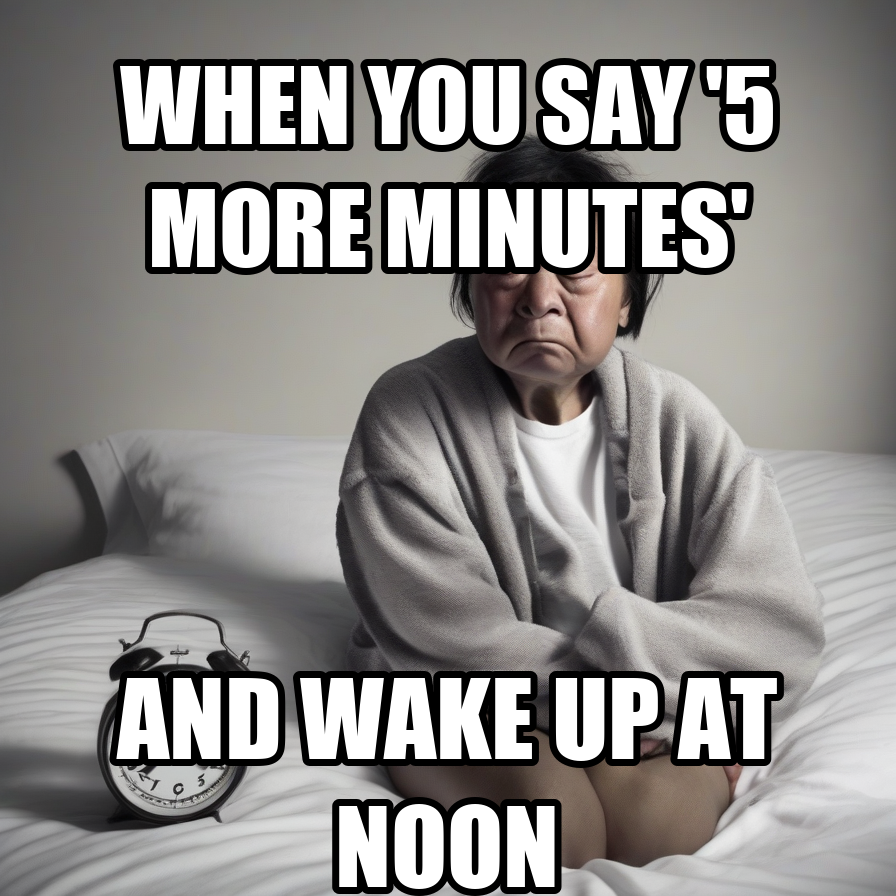

Meme generado y guardado en: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\data\processed\infer_samples\meme_sleep_late.png


In [50]:
from pathlib import Path
from PIL import Image
from IPython.display import display

# Prompt
PROMPT = (
    "sarcastic meme about saying 'just five more minutes' of sleep and waking up late, "
    "centered subject, plain background, soft lighting, high-contrast photo, stock photo style"
)
NEGATIVE = "watermark, logo, low quality, blurry, busy background, text overlay"

# Configuración de inferencia
GENERATOR = torch.Generator(device).manual_seed(123)
STEPS = 22
GUIDANCE = 6.3
SIZE = 896

# Generación
img = pipe(
    PROMPT,
    negative_prompt=NEGATIVE,
    num_inference_steps=STEPS,
    guidance_scale=GUIDANCE,
    width=SIZE,
    height=SIZE,
    generator=GENERATOR,
).images[0]

# Agregar texto tipo meme
img = add_meme_text(
    img,
    top_text="WHEN YOU SAY '5 MORE MINUTES'",
    bottom_text="AND WAKE UP AT NOON",
)

# Guardar y mostrar
OUT_DIR = Path("data/processed/infer_samples")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = OUT_DIR / "meme_sleep_late.png"
img.save(OUT_PATH)

display(Image.open(OUT_PATH))
print("Meme generado y guardado en:", OUT_PATH.resolve())

  0%|          | 0/30 [00:00<?, ?it/s]

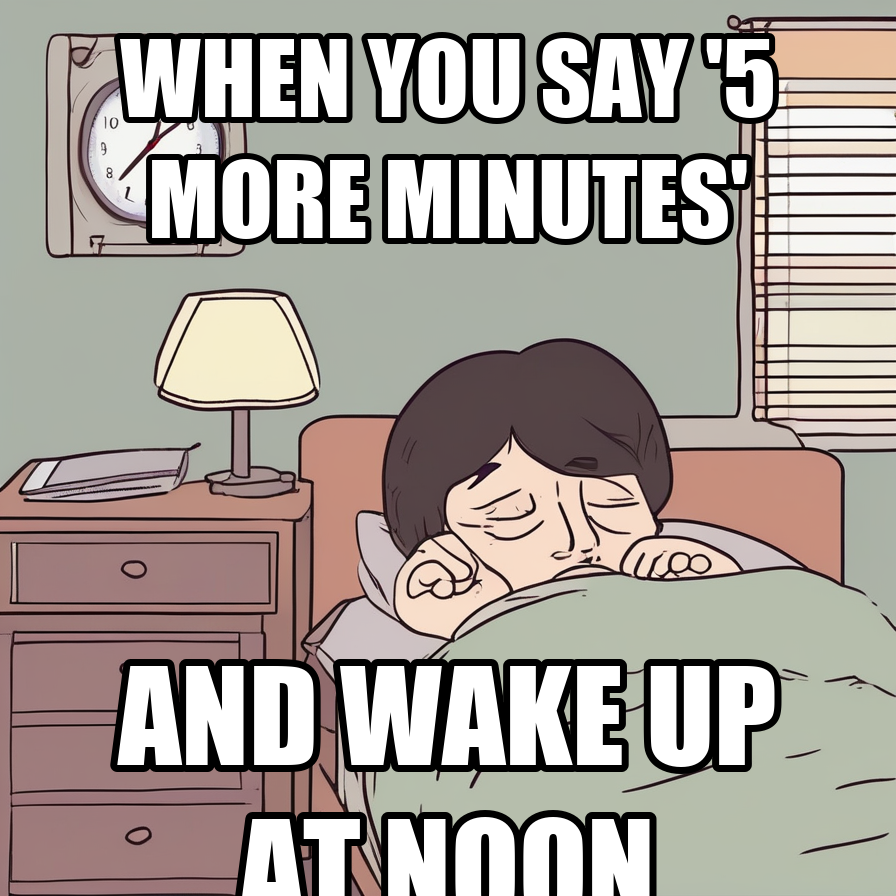

Meme generado y guardado en: C:\Users\fabri\Desktop\Portfolio\SarcasmDiffusion\data\processed\infer_samples\meme_sleep_late.png


In [45]:
# Prompt
PROMPT = (
    "sarcastic meme about saying 'just five more minutes' of sleep and waking up late, "
    "centered subject, plain background, soft lighting, high-contrast photo, stock photo style"
)
NEGATIVE = "watermark, logo, low quality, blurry, busy background, text overlay"

# Configuración de inferencia
GENERATOR = torch.Generator(device).manual_seed(42)
STEPS = 30
GUIDANCE = 6.3
SIZE = 896

# Generación
img = pipe(
    PROMPT,
    negative_prompt=NEGATIVE,
    num_inference_steps=STEPS,
    guidance_scale=GUIDANCE,
    width=SIZE,
    height=SIZE,
    generator=GENERATOR,
).images[0]

# Agregar texto tipo meme
img = add_meme_text(
    img,
    top_text="WHEN YOU SAY '5 MORE MINUTES'",
    bottom_text="AND WAKE UP AT NOON",
)

# Guardar y mostrar
OUT_DIR = Path("data/processed/infer_samples")
OUT_DIR.mkdir(parents=True, exist_ok=True)
OUT_PATH = OUT_DIR / "meme_sleep_late.png"
img.save(OUT_PATH)

display(Image.open(OUT_PATH))
print("Meme generado y guardado en:", OUT_PATH.resolve())